# Reduced K-Means Clustering

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

# yahoo finance used to fetch data 
import yfinance as yf
yf.pdr_override()

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [2]:
# input
symbols = ['AMD','AAPL','MSFT','GS', 'AMZN', 'GOOGL', 'TSLA', 'INTC']
start = '2021-01-01'
end = '2022-04-01'


# Read data 
df = yf.download(symbols,start,end)

# View Columns
df.head()

[*********************100%***********************]  8 of 8 completed


Adj Close                                                   \
                  AAPL        AMD         AMZN        GOOGL          GS   
Date                                                                      
2021-01-04  128.453445  92.300003  3186.629883  1726.130005  258.902100   
2021-01-05  130.041626  92.769997  3218.510010  1740.050049  264.695618   
2021-01-06  125.664215  90.330002  3138.379883  1722.880005  278.979187   
2021-01-07  129.952286  95.160004  3162.159912  1774.339966  284.938812   
2021-01-08  131.073929  94.580002  3182.699951  1797.829956  283.404968   

                                                    Close             ...  \
                 INTC        MSFT        TSLA        AAPL        AMD  ...   
Date                                                                  ...   
2021-01-04  48.050385  215.434967  729.770020  129.410004  92.300003  ...   
2021-01-05  48.959728  215.642792  735.109985  131.009995  92.769997  ...   
2021-01-06  49.433750  210.051300  755.979980  126.599998  90.330002  ...   
2021-01-07  50.488213  216.028732  816.039978  130.919998  95.160004  ...   
2021-01-08  49.965824  217.344971  880.020020  132.050003  94.580002  ...   

                  Open                 Volume                              \
                  MSFT        TSLA       AAPL       AMD     AMZN    GOOGL   
Date                                                                        
2021-01-04  222.529999  719.460022  143301900  51802600  4411400  1866200   
2021-01-05  217.259995  723.659973   97664900  34208000  2655500  1018000   
2021-01-06  212.169998  758.489990  155088000  51911700  4394800  2329400   
2021-01-07  214.039993  777.630005  109578200  42897200  3514500  2096800   
2021-01-08  218.679993  856.000000  105158200  39816400  3537700  1774200   

                                                   
                 GS      INTC      MSFT      TSLA  
Date                                               
2021-01-04  3572000  46102500  37130100  48638200  
2021-01-05  4207100  24866600  23823000  32245200  
2021-01-06  6383500  36809600  35930700  44700000  
2021-01-07  4009700  32092300  27694500  51498900  
2021-01-08  2800800  34625400  22956200  75055500  

[5 rows x 48 columns]

In [3]:
stock_open = np.array(df['Open']).transpose()
stock_close = np.array(df['Close']).transpose()


In [4]:
movements = stock_close - stock_open

sum_of_movement = np.sum(movements,1)

In [5]:
for i in range(len(symbols)):
    print('Symbols:{}, Change:{}'.format(df['High'].columns[i],sum_of_movement[i]))


Symbols:AAPL, Change:40.60997009277344
Symbols:AMD, Change:-31.269943237304688
Symbols:AMZN, Change:-801.45068359375
Symbols:GOOGL, Change:-34.5792236328125
Symbols:GS, Change:-15.619964599609375
Symbols:INTC, Change:-5.630008697509766
Symbols:MSFT, Change:34.880035400390625
Symbols:TSLA, Change:-27.66082763671875


In [6]:
# Define, Fit, and transform a Normalizer
normalizer = Normalizer()
norm_movements = normalizer.fit_transform(movements) 


In [7]:
# Create Kmeans model
normalizer = Normalizer()
kmeans = KMeans(max_iter = 1000)
pipeline = make_pipeline(normalizer,kmeans)
pipeline.fit(movements)
labels = pipeline.predict(movements)

In [8]:
df1 = pd.DataFrame({'labels':labels,'Symbols':symbols}).sort_values(by=['labels'],axis = 0)
df1 = df1.set_index('Symbols')
print('\n')
print(df1)



         labels
Symbols        
AMD           0
GOOGL         1
AMZN          2
TSLA          3
AAPL          4
MSFT          5
INTC          6
GS            7


In [9]:
# Reduce the data
normalizer = Normalizer()
reduced_data = PCA(n_components = 2)
kmeans = KMeans(max_iter = 1000)
pipeline = make_pipeline(normalizer,reduced_data,kmeans)
pipeline.fit(movements)
labels = pipeline.predict(movements)

In [10]:
df2 = pd.DataFrame({'labels':labels,'Symbols':symbols}).sort_values(by=['labels'],axis = 0)
df2 = df2.set_index('Symbols')
print('\n')
print(df2)



         labels
Symbols        
INTC          0
TSLA          1
AMZN          2
GOOGL         3
AMD           4
AAPL          5
GS            6
MSFT          7


In [11]:
# Reduce the data
reduced_data = PCA(n_components = 2).fit_transform(norm_movements)
h = 0.01
x_min,x_max = reduced_data[:,0].min()-1, reduced_data[:,0].max() + 1
y_min,y_max = reduced_data[:,1].min()-1, reduced_data[:,1].max() + 1
xx,yy = np.meshgrid(np.arange(x_min,x_max,h),np.arange(y_min,y_max,h))
Z = kmeans.predict(np.c_[xx.ravel(),yy.ravel()])
Z = Z.reshape(xx.shape)
cmap = plt.cm.Paired

<Figure size 432x288 with 0 Axes>

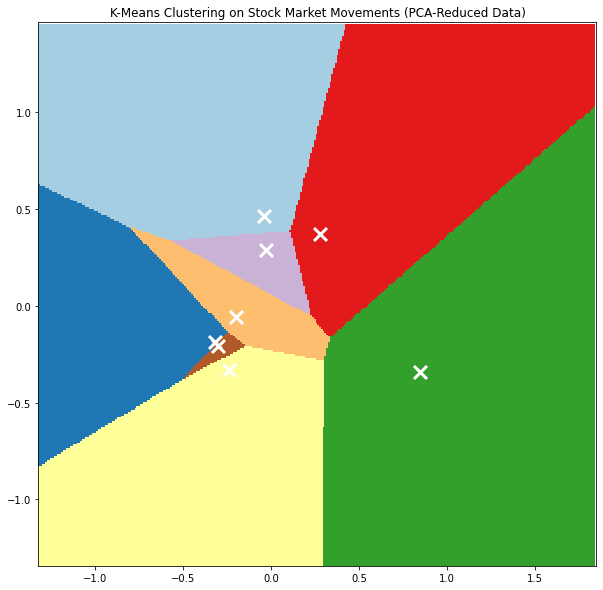

In [12]:
plt.clf()
plt.figure(figsize=(10,10))
plt.imshow(Z,interpolation = 'nearest',extent=(xx.min(),xx.max(),yy.min(),yy.max()),cmap = cmap,aspect = 'auto',origin = 'lower')
plt.plot(reduced_data[:,0],reduced_data[:,1],'k.',markersize = 5)

# Plot the centroid of each cluster as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:,0],centroids[:,1],marker = 'x',s = 169,linewidths = 3,color = 'w',zorder = 10)
plt.title('K-Means Clustering on Stock Market Movements (PCA-Reduced Data)')
plt.xlim(x_min,x_max)
plt.ylim(y_min,y_max)
plt.show()